# Final Project

## Project Description

For this project I am creating a simulation on an cart falling through the middle of the earth. A group of scientists are viewing this cart from one side of the earth. It starts at the surface and falls towards the center of the earth. There are wheels to keep the cart in place, which causes friction that reduces the acceleration of the car. The scientists measure the position of the cart every 20 seconds and form a graph showing where it is as time passes.


## Method
I will use two different models to simulate this cart. 

First I will take a physical approach by creating a 3d sphere of 20 units radius. This models the earth into a number of point masses which, together, would be the same mass as the earth. By assuming uniform density, each mass will have equal mass. An object is then placed on the top of the sphere, and for every second it calculates its acceleration caused by gravity, by summing up all the acceleration caused by individual point masses. This acceleration is added to the velocity every second, and the velocity is added to the distance every second. The acceleration is calculated using newton's equations of gravity.

The second way is using a mathematical approach. 
<br>
Force of gravity is calculated through this equation according to Isaac Newton
$$ F = G\frac{M_E m}{r^{2}}$$
Where $M_E$ is the mass of the earth
<br>
$m$ is the mass of the object
<br>
$G$ is the gravitational constant
<br>
$r^(2)$ is the distance between the center of masses of the objects
<br>
$M_E$ is changing as the radius decreases. In reality the gravitational forces of the earth above the current y position cancels out completely as the forces from the bottom is the same as the top.

Lets define $M(r)$ as the function for mass at $r$ radius. Mass = density * volume
<br>
$$M(r) = \rho \frac{4}{3} \pi r^3$$
<br>
Where $\rho$ is the density of the earth

<br>
We can calculate $\rho$ by dividing mass of the earth with the volume of the earth.
$$\rho = \frac{M_E}{\frac{4}{3} \pi R^3}$$
<br>
Where $R$ is the radius of the earth
<br>
Therefore, combining these equations we get
$$M(r) = \frac{M_E r^3}{R^3}$$ 
<br>
Now we get the force of gravity at $r$ by setting $M_E$ in the first equation as $M(r)$
$$F(r) = G \frac{M_E r m}{R^3}$$
<br>
As $F = ma$, acceleration at $r$ will equal to
$$a(r) = G \frac{M_E r}{R^3}$$
<br>

Using these methods I can form a dataset with the times and positions of the particles. 

## Analysis

Next I will use emcee evaluation to analyze the data, finding the points that corresponds to the lowest chi-squared. This data will be used to plot a corner graph to visualize how well my analysis went.

In [215]:
import numpy as np
import matplotlib.pylab as plt
total_weight = 5.972*10**24


Here the 3d space the sphere resides in is created. 

In [77]:
tdarr = np.ndarray(shape=(40,40,40))

In [78]:
for x in range(len(tdarr[0,:,:])):
    for y in range(len(tdarr[:,0,:])):
        for z in range(len(tdarr[:,:,0])):
            if (tdarr[x,y,z] != 0):
                tdarr[x,y,z] = 0

I used a mask to create a sphere that centers at (20,20,20) with the radius of 20 as to fit in the whole space

In [79]:
lx, ly, lz = tdarr.shape
X, Y, Z = np.ogrid[0:lx, 0:ly, 0:lz]
def inside(X,Y,Z):
    return (X - 20) ** 2 + (Y -20) ** 2 + (Z-20)**2< 400

I count up the number of points that is within the sphere and set them to 1 to indicate that they are the sphere.

In [80]:
count = 0
for x in range(len(tdarr[0,:,:])):
    for y in range(len(tdarr[:,0,:])):
        for z in range(len(tdarr[:,:,0])):
            if (inside(x,y,z)):
                tdarr[x,y,z] = 1
                count += 1
            

In [81]:
avg_weight = total_weight/count

Now the average weight is calculated by the number of point masses and each point was assigned the same average mass

In [82]:
for x in range(len(tdarr[0,:,:])):
    for y in range(len(tdarr[:,0,:])):
        for z in range(len(tdarr[:,:,0])):
            if (tdarr[x,y,z] == 1):
                tdarr[x,y,z] = avg_weight

Initializing the correct starting variables for the simulation

In [83]:
earth_d = 6.371 * 10**6*2
pixel_d = earth_d/39
mass = 1
velocity = 0
xpos = 20 * pixel_d
ypos = 0 
zpos = 20 * pixel_d
frictional_force = 0.5 #newtons
g = 6.67408 * 10**(-11) #gravitational constant


Simulation is ran.

In [88]:
import math
length = 200 #length of the run. 200*20 or 4000 seconds. The object will fall little over an hour.
time = np.zeros(length)
simulation = np.zeros(length) #recording the data
velocity = 0
ypos = 0
for i in range(0,length):
    for _ in range(0, 20): # every 20 seconds the position is recorded so that emcee won't have to go through every single point. 
        acceleration = 0
        for y in range(len(tdarr[:,0,:])):
            for x in range(len(tdarr[0,:,:])):
                for z in range(len(tdarr[:,:,0])):
                    if (tdarr[x,y,z] != 0):
                        r_2 = (y*pixel_d-ypos)**2+(x*pixel_d-xpos)**2+(z*pixel_d-zpos)**2 #distance squared between point and the object
                        force = g*mass*tdarr[x,y,z]/r_2

                        if (math.sqrt((xpos-x*pixel_d)**2+(z*pixel_d-zpos)**2) ==0): #if the block is the same block the object is on. Don't calculate the force because it is too high.
                            if (y*pixel_d-ypos < pixel_d):
                                acceleration += 0
                            else:
                                acceleration += force/mass
                        else:
                            acceleration +=  np.sin(np.arctan((ypos-y*pixel_d)/math.sqrt((xpos-x*pixel_d)**2+(z*pixel_d-zpos)**2)))*force/mass 
                            #Record only the vertical component of the force.
        print(i, acceleration, velocity)
        velocity -= frictional_force*np.sign(velocity) #frictional force is applied opposite to the direction of movement

        velocity += acceleration
        ypos -= velocity
    simulation[i] = ypos #record the position
    time[i] = i*20
    

0 -8.67437149955116 0
0 -8.786275962356692 -8.67437149955116
0 -8.786301859759304 -16.960647461907854
0 -8.786340407200392 -25.24694932166716
0 -8.786391601899556 -33.53328972886755
0 -8.786455440162666 -41.81968133076711
0 -8.78653191738106 -50.10613677092978
0 -8.786621028028197 -58.39266868831084
0 -8.78672276565879 -66.67928971633904
0 -8.78683712290737 -74.96601248199784
0 -8.786964091483812 -83.25284960490521
0 -8.787103662171237 -91.53981369638902
0 -8.78725582482376 -99.82691735856025
0 -8.7874205683614 -108.11417318338401
0 -8.787597880766137 -116.40159375174541
0 -8.787787749079424 -124.68919163251155
0 -8.787990159395811 -132.97697938159098
0 -8.788205096858293 -141.26496954098678
0 -8.788432545653666 -149.55317463784507
0 -8.788672489007244 -157.84160718349875
1 -8.788924909175257 -166.130279672506
1 -8.789189787440185 -174.41920458168124
1 -8.789467104103915 -182.70839436912144
1 -8.789756838479443 -190.99786147322536
1 -8.790058968884717 -199.2876183117048
1 -8.7903734726

10 -8.942028715199667 -1713.2926197110987
10 -8.941945925305967 -1721.7346484262985
10 -8.941821660741583 -1730.1765943516045
10 -8.94165510426681 -1738.6184160123462
10 -8.941445435605589 -1747.060071116613
10 -8.941191831866554 -1755.5015165522186
10 -8.940893467988577 -1763.942708384085
10 -8.940549517204454 -1772.3836018520738
10 -8.94015915152262 -1780.8241513692783
10 -8.939721542228815 -1789.264310520801
10 -8.939235860411928 -1797.70403206303
10 -8.938701277498057 -1806.1432679234417
10 -8.938116965815732 -1814.5819692009397
10 -8.93748209917077 -1823.0200861667554
10 -8.93679585344643 -1831.457568265926
11 -8.936057407214234 -1839.8943641193725
11 -8.935265942369025 -1848.3304215265869
11 -8.934420644777026 -1856.7656874689558
11 -8.933520704940086 -1865.2001081137328
11 -8.93256531867493 -1873.6336288186728
11 -8.931553687811261 -1882.0661941373478
11 -8.930485020892673 -1890.497747825159
11 -8.929358533901913 -1898.9282328460517
11 -8.928173450985458 -1907.3575913799536
11 -

20 -8.389782906117555 -3342.9705481318506
20 -8.38359589552757 -3350.860331037968
20 -8.377410558963927 -3358.7439269334955
20 -8.371229441951607 -3366.6213374924596
20 -8.365054998390367 -3374.492566934411
20 -8.358889577452455 -3382.3576219328015
20 -8.352735410746648 -3390.216511510254
20 -8.346594599816925 -3398.0692469210007
20 -8.340469104046253 -3405.9158415208176
20 -8.334360729028237 -3413.756310624864
20 -8.328271115472333 -3421.590671353892
20 -8.322201728706865 -3429.4189424693645
20 -8.316153848825728 -3437.241144198071
20 -8.310128561546776 -3445.057298046897
20 -8.304126749826054 -3452.8674266084436
20 -8.298149086268463 -3460.6715533582696
20 -8.292196026388352 -3468.469702444538
21 -8.286267802746032 -3476.2618984709266
21 -8.280364420004796 -3484.0481662736725
21 -8.274485650924952 -3491.8285306936773
21 -8.268631033325779 -3499.603016344602
21 -8.262799868035195 -3507.3716473779277
21 -8.256991217835793 -3515.1344472459627
21 -8.25120390742466 -3522.8914384637987
21 

30 -7.144470935200569 -4793.277008098037
30 -7.1367398579062655 -4799.921479033238
30 -7.128909602391751 -4806.558218891144
30 -7.120970956828904 -4813.187128493536
30 -7.112914994204506 -4819.808099450365
30 -7.104733128476978 -4826.42101444457
30 -7.096417167817851 -4833.025747573047
30 -7.0879593643416 -4839.622164740865
30 -7.079352459695705 -4846.210124105206
30 -7.070589725877141 -4852.789476564902
30 -7.061665000636293 -4859.360066290778
30 -7.052572716812921 -4865.921731291414
30 -7.0433079249677695 -4872.474304008228
30 -7.033866308674492 -4879.017611933195
30 -7.024244191859455 -4885.5514782418695
30 -7.014438537608937 -4892.075722433729
30 -7.004446937890371 -4898.590160971338
30 -6.994267593692006 -4905.094607909228
31 -6.983899285132447 -4911.58887550292
31 -6.973341331155032 -4918.072774788053
31 -6.962593538492647 -4924.546116119208
31 -6.951656139655526 -4931.008709657701
31 -6.940529719780442 -4937.460365797357
31 -6.92921513224581 -4943.900895517137
31 -6.917713403031

40 -5.531669374517145 -5969.971521746973
40 -5.518338913080572 -5975.00319112149
40 -5.5047421503783145 -5980.021530034571
40 -5.4908814895608336 -5985.026272184949
40 -5.476759366798925 -5990.01715367451
40 -5.462377934952517 -5994.9939130413095
40 -5.447738717181278 -5999.956290976262
40 -5.547413632664103 -6004.904029693443
40 -5.536646061492692 -6009.9514433261065
40 -5.525878215843827 -6014.988089387599
40 -5.515126218533728 -6020.013967603442
40 -5.504405604239263 -6025.029093821976
40 -5.493731084577103 -6030.033499426215
40 -5.483116324340432 -6035.027230510792
40 -5.472573732434942 -6040.010346835133
40 -5.462114270743921 -6044.982920567568
40 -5.451747283758888 -6049.945034838312
40 -5.441480351368658 -6054.89678212207
41 -5.431319166736296 -6059.838262473439
41 -5.42126744069494 -6064.769581640175
41 -5.411326833592052 -6069.69084908087
41 -5.401496915039676 -6074.602175914462
41 -5.391775151556755 -6079.503672829502
41 -5.382156921670155 -6084.395447981058
41 -5.37263555765

50 -3.7035202698934166 -6804.406047190628
50 -3.689487380821628 -6807.609567460521
50 -3.6751080199027366 -6810.799054841343
50 -3.6603828795154794 -6813.9741628612455
50 -3.6453141733102385 -6817.134545740761
50 -3.6299052326279733 -6820.279859914071
50 -3.614160033413629 -6823.409765146698
50 -3.598082655808686 -6826.523925180112
50 -3.5816766792857795 -6829.622007835921
50 -3.677123435290176 -6832.703684515207
50 -3.6649175096293027 -6835.880807950497
50 -3.6527076962560274 -6839.045725460126
50 -3.640517905575039 -6842.198433156382
50 -3.6283711153099776 -6845.338951061956
50 -3.6162889269829224 -6848.467322177266
50 -3.6042911482531728 -6851.583611104249
50 -3.5923954095283706 -6854.687902252502
50 -3.580616822250766 -6857.7802976620305
51 -3.568967685102126 -6860.860914484281
51 -3.557457243048984 -6863.929882169384
51 -3.546091502788671 -6866.987339412432
51 -3.5348731067546852 -6870.033430915221
51 -3.523801266504751 -6873.068304021976
51 -3.5128717550399036 -6876.0921052884805

60 -1.7515883385735707 -7247.6107517607215
60 -1.7388418863912536 -7248.862340099295
60 -1.726201925342404 -7250.101181985686
60 -1.7136879941585261 -7251.327383911028
60 -1.7013162714539243 -7252.541071905186
60 -1.689099231032117 -7253.74238817664
60 -1.677045375210364 -7254.931487407672
60 -1.6651590497903759 -7256.108532782882
60 -1.6534403421369832 -7257.273691832673
60 -1.641885061806995 -7258.42713217481
60 -1.630484801349968 -7259.569017236618
60 -1.6192270733201772 -7260.699502037967
60 -1.6080955182474268 -7261.818729111287
60 -1.5970701772823648 -7262.926824629535
60 -1.5861278224770035 -7264.023894806817
60 -1.57524233713399 -7265.110022629294
60 -1.564385138330661 -7266.185264966428
60 -1.55352563353841 -7267.249650104759
60 -1.5426317031863401 -7268.303175738298
60 -1.5316702009766674 -7269.345807441484
61 -1.5206074637677685 -7270.377477642461
61 -1.5094098227967037 -7271.398085106229
61 -1.4980441079598068 -7272.407494929025
61 -1.486478136768439 -7273.405539036985
61 -

69 0.30826877987065254 -7288.653367067358
69 0.3191571612670822 -7287.845098287487
69 0.330081020010413 -7287.0259411262205
69 0.341073800180512 -7286.19586010621
69 0.35216935707267794 -7285.354786306029
70 0.3634014399964663 -7284.5026169489565
70 0.3748031850573735 -7283.63921550896
70 0.3864066263716697 -7282.764412323902
70 0.3982422342431648 -7281.878005697531
70 0.4103384889116787 -7280.979763463288
70 0.42272149855816055 -7280.0694249743765
70 0.4354146702444175 -7279.146703475818
70 0.44843844234964264 -7278.2112888055735
70 0.461810086804752 -7277.262850363224
70 0.4755435889578036 -7276.301040276419
70 0.48964961219526115 -7275.325496687462
70 0.5041355535109467 -7274.335847075266
70 0.5190056950015913 -7273.331711521755
70 0.5342614548568554 -7272.312705826754
70 0.5499017397893188 -7271.2784443718965
70 0.5659233991418495 -7270.228542632107
70 0.5823217791556967 -7269.162619232965
70 0.5990913742400745 -7268.080297453809
70 0.6162265706545479 -7266.981206079569
70 0.633722

79 2.3979085303887486 -6917.37688006161
79 2.4125952034248916 -6914.478971531221
79 2.4276240865161087 -6911.566376327796
79 2.442991526503828 -6908.63875224128
80 2.458692863218962 -6905.695760714776
80 2.474722965384615 -6902.737067851557
80 2.491076830642073 -6899.762344886172
80 2.507750245158191 -6896.7712680555305
80 2.4107093249311817 -6893.763517810372
80 2.4230007796197697 -6890.852808485441
80 2.435275606827975 -6887.929807705821
80 2.44750978199492 -6884.994532098993
80 2.4596805488481532 -6882.047022316998
80 2.471766854113305 -6879.08734176815
80 2.4837497461687312 -6876.115574914036
80 2.4956127300306976 -6873.131825167868
80 2.507342072333419 -6870.136212437837
80 2.5189270514120867 -6867.128870365503
80 2.530360149086029 -6864.109943314091
80 2.541637182210338 -6861.079583165005
80 2.5527573735239537 -6858.037945982795
80 2.5637233626313303 -6854.98518860927
80 2.574541159150744 -6851.921465246639
80 2.585220041083985 -6848.846924087488
81 2.595772402289845 -6845.761704

89 4.322313338949809 -6138.211162495287
90 4.336403388608359 -6133.388849156337
90 4.350745289243484 -6128.552445767728
90 4.365335346744887 -6123.701700478485
90 4.380170497298633 -6118.8363651317395
90 4.281340776435223 -6113.956194634441
90 4.292238914034069 -6109.174853858006
90 4.303122229519046 -6104.382614943972
90 4.31397387375807 -6099.5794927144525
90 4.324777749621162 -6094.765518840694
90 4.335518751125664 -6089.9407410910735
90 4.346182985197243 -6085.105222339947
90 4.356757972728641 -6080.25903935475
90 4.367232826111031 -6075.402281382021
90 4.377598400951285 -6070.53504855591
90 4.387847420281192 -6065.6574501549585
90 4.397974570113035 -6060.769602734677
90 4.407976565795332 -6055.871628164565
90 4.417852189139101 -6050.9636515987695
90 4.427602296802189 -6046.0457994096305
90 4.4372298008637 -6041.118197112828
91 4.4467396229091145 -6036.180967311964
91 4.456138623281164 -6031.234227689055
91 4.465435507407797 -6026.278089065774
91 4.474640711325039 -6021.31265355836

100 5.908220476391041 -4986.186916301032
100 5.91567687947653 -4979.7786958246415
100 5.923116761373566 -4973.363018945165
100 5.930550125419376 -4966.939902183792
100 5.93798720564787 -4960.509352058372
100 5.945438388387522 -4954.071364852724
100 5.952914134364456 -4947.625926464337
100 5.960424901876704 -4941.173012329972
100 5.967981071599619 -4934.7125874280955
100 5.975592873555382 -4928.244606356496
100 5.983270316768606 -4921.76901348294
100 5.991023122107942 -4915.285743166171
100 5.998860658806506 -4908.794720044063
100 6.00679188513092 -4902.295859385256
100 6.01482529366009 -4895.789067500125
100 6.022968861622302 -4889.274242206466
101 6.031230006710809 -4882.751273344844
101 6.039615548791475 -4876.220043338133
101 6.048131677885203 -4869.680427789342
101 6.056783928783734 -4863.1322961114565
101 6.065577162629199 -4856.575512182672
101 6.074515555745985 -4850.0099350200435
101 6.083602595978284 -4843.435419464297
101 6.092841086740717 -4836.8518168683195
101 6.1022331589

110 7.113811959809415 -3580.1742933350106
110 7.120230249036584 -3572.560481375201
110 7.126625752588927 -3564.9402511261646
110 7.1329953092618705 -3557.3136253735756
110 7.139335901020235 -3549.680630064314
110 7.145644666461699 -3542.0412941632935
110 7.151918913162308 -3534.395649496832
110 7.1581561288574385 -3526.7437305836697
110 7.164353991431251 -3519.085574454812
110 7.170510377684257 -3511.421220463381
110 7.1766233708642595 -3503.7507100856965
110 7.182691266963424 -3496.0740867148324
110 7.188712579771961 -3488.391395447869
110 7.1946860447100995 -3480.702682868097
110 7.200610621451325 -3473.0079968233867
110 7.206485495367123 -3465.3073862019355
110 7.212310077823505 -3457.6009007065686
111 7.21808400536888 -3449.888590628745
111 7.2238071378573965 -3442.1705066233762
111 7.22947955555769 -3434.446699485519
111 7.235101555298394 -3426.717219929961
111 7.240673645707122 -3418.9821183746626
111 7.246196541601171 -3411.2414447289557
111 7.2516711575916455 -3403.495248187354

120 7.960174673260046 -1979.9792847907331
120 7.963871555397138 -1971.519110117473
120 7.967578939116962 -1963.0552385620758
120 7.971296717893775 -1954.5876596229589
120 7.975024762967206 -1946.1163629050652
120 7.978762924194416 -1937.641338142098
120 7.9825110309166165 -1929.1625752179036
120 7.986268892839565 -1920.680064186987
120 7.990036300929438 -1912.1937952941475
120 7.9938130283143956 -1903.7037589932181
120 7.997598831197852 -1895.2099459649037
120 8.001393449774838 -1886.7123471337059
120 8.005196609151026 -1878.210953683931
120 8.00900802026575 -1869.70575707478
120 8.012827380811268 -1861.1967490545142
120 8.01665437615083 -1852.6839216737028
120 8.020488680231372 -1844.167267297552
120 8.02432995649091 -1835.6467786173205
120 8.028177858754324 -1827.1224486608296
121 8.032032032123347 -1818.5942708020752
121 8.035892113851034 -1810.0622387699518
121 8.039757734205262 -1801.5263466561007
121 8.04362851731711 -1792.9865889218954
121 8.047504082011182 -1784.4429604045783
1

130 8.266316791360957 -258.49689922698474
130 8.266693279962428 -249.73058243562377
130 8.267056490732278 -240.96388915566135
130 8.267406430669975 -232.19683266492908
130 8.267743106346021 -223.4294262342591
130 8.268066523921172 -214.66168312791308
130 8.26837668916491 -205.89361660399192
130 8.26867360747207 -197.125239914827
130 8.268957283880694 -188.35656630735494
130 8.26922772308731 -179.58760902347424
130 8.269484929463532 -170.81838130038693
130 8.26972890707042 -162.0488963709234
130 8.269959659673264 -153.27916746385296
130 8.270177190754893 -144.50920780417968
130 8.270381503528464 -135.7390306134248
130 8.270572600950665 -126.96864910989633
130 8.270750485731016 -118.19807650894566
130 8.270915160346705 -109.42732602321465
130 8.27106662704794 -100.65641086286794
130 8.27120488787125 -91.88534423582
131 8.271329944645647 -83.11413934794875
131 8.271441799002357 -74.34280940330311
131 8.271540452380624 -65.57136760430075
131 8.271625906034897 -56.79982715192013
131 8.27169

140 8.076084177764363 1346.0202254773199
140 8.073646478125465 1353.5963096550843
140 8.071193422817776 1361.1699561332098
140 8.068725171011293 1368.7411495560275
140 8.066241889794467 1376.3098747270387
140 8.063743754217397 1383.876116616833
140 8.061230947321457 1391.4398603710504
140 8.058703660160733 1399.001091318372
140 8.056162091810227 1406.5597949785326
140 8.053606449361155 1414.1159570703428
140 8.051036947906114 1421.6695635197038
140 8.048453810509299 1429.22060046761
140 8.045857268163099 1436.7690542781193
140 8.043247559732432 1444.3149115462822
140 8.040624931883377 1451.8581591060147
140 8.149040233523776 1459.3987840378982
141 8.145405426065997 1467.0478242714219
141 8.14176634362277 1474.6932296974878
141 8.138123237319771 1482.3349960411106
141 8.13447636449441 1489.9731192784304
141 8.130825988570518 1497.607595642925
141 8.127172378916812 1505.2384216314954
141 8.12351581068453 1512.8655940104122
141 8.119856564629531 1520.4891098210967
141 8.11619492691305 152

150 7.503197252036724 2829.402265294883
150 7.49774472922851 2836.40546254692
150 7.492335477526462 2843.4032072761484
150 7.48696925371483 2850.395542753675
150 7.481645726818658 2857.38251200739
150 7.476364476107335 2864.364157734208
150 7.471124989411392 2871.3405222103156
150 7.465926661760612 2878.311647199727
150 7.46076879435144 2885.2775738614873
150 7.455650593846005 2892.2383426558386
150 7.4505711720102346 2899.1939932496844
150 7.445529545696486 2906.1445644216947
150 7.440524637169349 2913.090093967391
150 7.435555274782823 2920.0306186045605
151 7.430620194004436 2926.9661738793434
151 7.4257180387918496 2933.896794073348
151 7.420847363320061 2940.8225121121395
151 7.416006634056629 2947.74335947546
151 7.411194232184979 2954.659366109516
151 7.406408456375536 2961.5705603417014
151 7.4016475258937025 2968.476968798077
151 7.396909584051871 2975.3786163239706
151 7.392192701988302 2982.2755259080227
151 7.387494882777443 2989.167718610011
151 7.382814065859945 2996.0552

160 6.4563558895431 4150.73143137313
160 6.449818903207532 4156.687787262674
160 6.443331370675397 4162.637606165881
160 6.436887419811984 4168.580937536556
160 6.4304810260235 4174.517824956368
160 6.424106041193408 4180.4483059823915
160 6.4177562239196595 4186.372412023585
160 6.411425270905044 4192.290168247504
160 6.405106849342815 4198.201593518409
160 6.398794630141303 4204.106700367752
160 6.392482321812165 4210.005494997893
161 6.386163704856137 4215.897977319705
161 6.379832666458095 4221.784141024561
161 6.373483235309357 4227.663973691019
161 6.367109616353437 4233.537456926329
161 6.360706225257748 4239.404566542682
161 6.354267722397991 4245.26527276794
161 6.347789046131775 4251.119540490337
161 6.341265445139278 4256.967329536469
161 6.33469250959563 4262.808594981609
161 6.328066200937357 4268.643287491204
161 6.321382879978632 4274.471353692142
161 6.314639333133552 4280.292736572121
161 6.307832796495403 4286.107375905254
161 6.300960977531316 4291.915208701749
161 6

170 5.070656136071211 5236.480488380058
170 5.062187374056364 5241.051144516129
170 5.053830047979473 5245.613331890186
170 5.045573021263236 5250.167161938165
170 5.037404665612835 5254.712734959428
170 5.029312946369823 5259.250139625041
171 5.021285513200302 5263.779452571411
171 5.013309795301493 5268.300738084611
171 5.005373100315258 5272.814047879912
171 4.997462716111763 5277.319420980228
171 4.989566014608064 5281.81688369634
171 4.981670556746313 5286.306449710948
171 4.973764197765401 5290.7881202676945
171 4.965835191852428 5295.26188446546
171 4.957872295255711 5299.727719657312
171 4.949864866909813 5304.185591952568
171 4.941802965594348 5308.635456819477
171 4.9336774426488486 5313.077259785072
171 4.925480029218241 5317.510937227721
171 4.917203417029079 5321.936417256939
171 4.908841331672371 5326.353620673968
171 4.900388597394187 5330.76246200564
171 4.8918411924167575 5335.162850603035
171 4.883196293865594 5339.554691795452
171 4.874452311426716 5343.937888089317


180 3.3930881221976 6005.344284232723
180 3.3824562942382257 6008.237372354921
181 3.3717756850535707 6011.119828649159
181 3.361061419502645 6013.991604334213
181 3.3503293923037885 6016.852665753715
181 3.451074752256506 6019.702995146019
181 3.43636473464475 6022.654069898275
181 3.4218955453201634 6025.59043463292
181 3.407669495570859 6028.51233017824
181 3.393689651477006 6031.419999673811
181 3.3799594766808565 6034.313689325288
181 3.366482499310005 6037.193648801968
181 3.353262004980081 6040.0601313012785
181 3.340300757723142 6042.9133933062585
181 3.3276007505122958 6045.753694063982
181 3.3151629867729246 6048.581294814494
181 3.3029872939538225 6051.3964578012665
181 3.2910721698455307 6054.199445095221
181 3.279414661941512 6056.990517265066
181 3.2680102797327457 6059.769931927008
181 3.2568529394345442 6062.537942206741
181 3.245934940274646 6065.294795146176
182 3.2352469711426988 6068.04073008645
182 3.224778146102365 6070.775977057592
182 3.214516067023725 6073.5007

191 1.590055616488335 6417.561858447623
191 1.57930972518161 6418.651914064111
191 1.568435719855138 6419.731223789293
191 1.5574407021593464 6420.799659509148
191 1.546334168660412 6421.857100211308
191 1.535127857478804 6422.903434379968
191 1.523835557138741 6423.938562237447
191 1.5124728801141019 6424.962397794586
191 1.5010570044060718 6425.9748706747
191 1.4896063872717087 6426.975927679106
191 1.478140455953273 6427.965534066378
191 1.5774021791831048 6428.943674522331
191 1.5617546258865518 6430.021076701514
191 1.546387489393083 6431.0828313274005
191 1.5313035720187476 6432.129218816794
191 1.5165064975675155 6433.160522388813
191 1.5020002273065767 6434.17702888638
191 1.4877886150591562 6435.179029113687
191 1.4738750040903292 6436.166817728746
192 1.4602618682402586 6437.140692732836
192 1.4469504993409807 6438.100954601076
192 1.4339407424391106 6439.047905100418
192 1.4212307797338168 6439.981845842857
192 1.408816963479972 6440.903076622591
192 1.396693697452723 6441.8

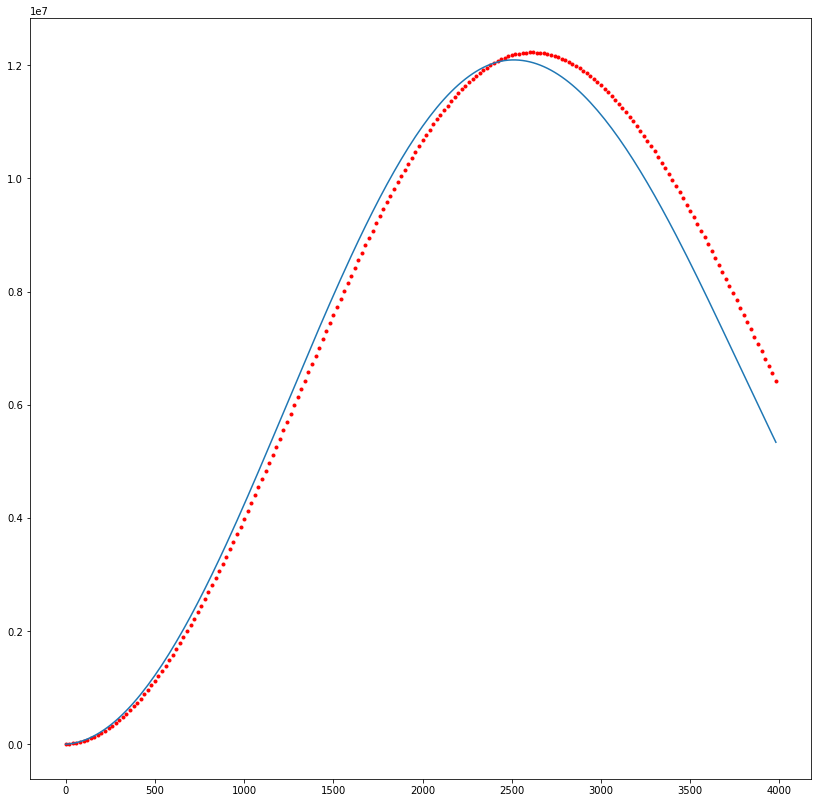

In [141]:
plt.figure(figsize=(14,14))
plt.scatter(time, simulation, marker=".", color="red")
plt.plot(time, true_value(200, frictional_force= 0.5))
print()

I am generating noise based on the distance. As the scientist uses a device to look down at the object, if the object is further away, the data becomes more varied as it is harder to make out where the object is. 

In [93]:
noisy = np.zeros(len(simulation))
for i in range(0, len(simulation)):
    
    sigma = simulation[i] /30
    noise = np.random.normal(mu, sigma)
    noisy[i] = simulation[i] + noise

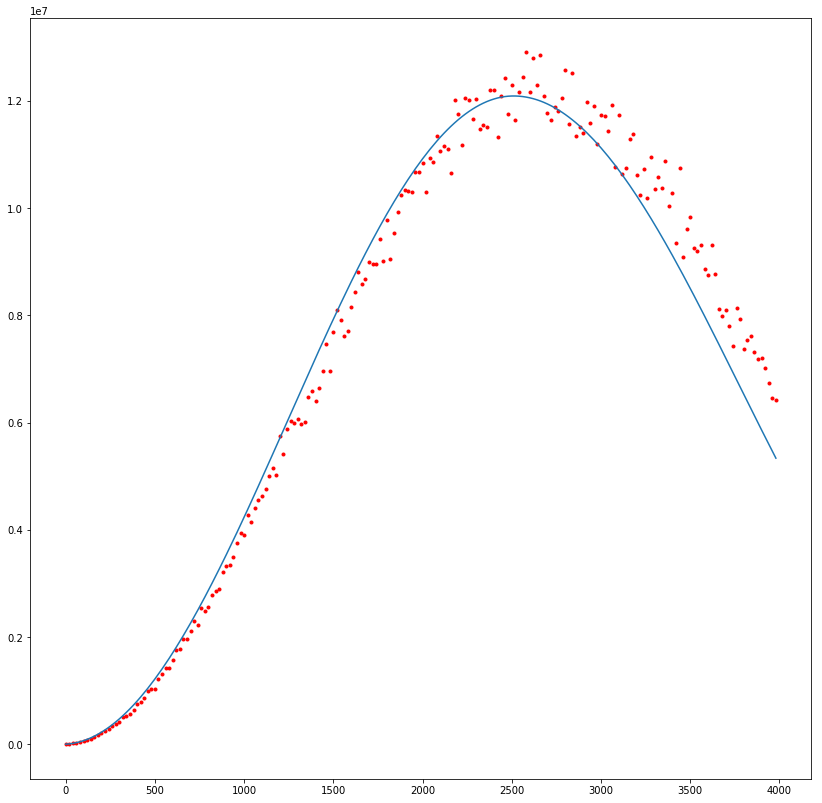

In [227]:
plt.figure(figsize=(14,14))
plt.scatter(time, noisy, marker=".", color="red")
plt.plot(time, true_value(200, frictional_force= 0.5))


Function that uses the mathematical derivation to find out the correct acceleration

In [3]:
def acc(r, v, earth_r =  6.371 * 10**6, G = 6.67408 * 10**(-11), frictional_force = 0.5,total_weight = 5.972*10**24):
    r = r - earth_r #because the distance recorded is always positive, this must be applied so that the radius is relative to the center of the earth rather than the top
    frictional_force *= np.sign(v) #frictional force is opposite to direction
    return -G*total_weight*r/(earth_r**3)-frictional_force #this is the equation from the introduction

Function that accepts different parameters and performs a simulation by calculating the acceleration

In [4]:
def true_value(length, earth_r =  6.371 * 10**6, G = 6.67408 * 10**(-11), frictional_force = 0.5,total_weight = 5.972*10**24):
    distance = np.zeros(length)
    acceleration = 0
    velocity = 0
    ypos = 0
    #the same simulation is done but with calculating instead of running through 3 nested for loops
    for i in range(0,length): 
        for _ in range(0, 20):
            acceleration = acc(ypos, velocity, earth_r, G, frictional_force, total_weight)
            velocity += acceleration
            ypos += velocity
        distance[i] = ypos
    return distance


Here I demonstrate the function by making a graph showing how the object falls in 2000 runs or 40000 seconds (11 hours)

In [153]:

t = np.linspace(0,1999, 2000)
data = true_value(2000)


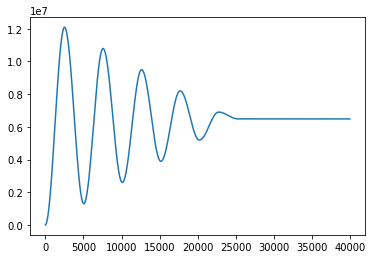

In [155]:
t = t *20
plt.plot(t, data)


### Analysis
I created a function calculating chi-squared for certain values of earth's radius, gravitational constant, frictional force and total weight. I also set some boundaries to indicate around where the true value should be. As emcee cannot find the value in terms of different orders of magnitudes, I use the value of the guess and multiply it by the order of magnitude when passing it through the true_value function

In [229]:

def chi_squared(parameters_guess, data):
    length = 200 #preset length
    earth_r, G, frictional_force, total_weight = parameters_guess
    t_array = data[:,0]
    x_experiment = data[:,1]
    
    #boudaries for the values. Return np.inf so that the walker won't move here
    if earth_r<5 or earth_r>8:
       # print("er", earth_r)
        return np.inf
    if (G < 4.5 or G > 7.5):
     #   print("g", G)
        return np.inf
    if (frictional_force < -1 or frictional_force > 2):
    #    print("ff", frictional_force)
        return np.inf
    if (total_weight < 4 or total_weight > 8):
       # print("tw", total_weight)
        return np.inf
    
    x_guess = true_value(length, earth_r* 10**6, G* 10**(-11), frictional_force, total_weight*10**24)
    chi_squared = np.power((x_guess - x_experiment),2)/(0.04)
    #print("chisq", np.sum(chi_squared))
    return np.sum(chi_squared)
    

Here I show that my chi-squared function is operational by changing one parameter. 

In [163]:
earth_r_g = 6.371
G_g = 6.67408
frictional_force_g = 0.5
total_weight_g = 5.972

x = np.linspace(5, 7, 1000)
optimize = np.zeros(len(x))


In [171]:
d_out = np.vstack((np.linspace(0,199,200)*20, true_value(200))).transpose()
for i in range(0,1000):
    optimize[i] = chi_squared([x[i], G_g, frictional_force_g, total_weight_g], d_out)

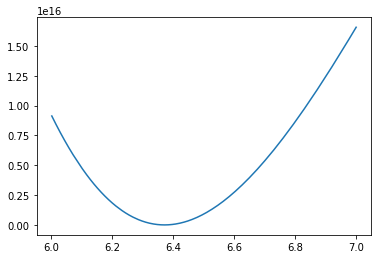

In [172]:
plt.plot(x, optimize)
#as you can see the lowest point is the correct value.

### Emcee
Now I use emcee to find the values that fit with my data.

In [230]:
import emcee
#set priors
earth_r_g = 6
G_g = 6
frictional_force_g = 0.3
total_weight_g = 5

#number of walkers in the simulation
nwalkers = 1000
ndim = 4
d_out = np.vstack((np.linspace(0,199,200)*20,noisy)).transpose()
parameters = [0,0,0,0]

sampler = emcee.EnsembleSampler(nwalkers, ndim, chi_squared, args=[d_out])
p0 = [earth_r_g, G_g, frictional_force_g, total_weight_g]+np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
print(p0)


[[6.56630805 6.24541152 0.45723112 5.55169258]
 [6.46670753 6.56843315 0.65101301 5.9021599 ]
 [6.92678674 6.96985179 0.75138914 5.82887812]
 ...
 [6.12713583 6.04835095 1.29727372 5.65855479]
 [6.39900465 6.97510455 0.85510248 5.20386477]
 [6.714793   6.98802486 0.91358074 5.5584338 ]]


In [231]:
pos, prob, state = sampler.run_mcmc(p0, 1000) 
#This code took me 2 hours to run so I cant really go above 1000 nsteps. 

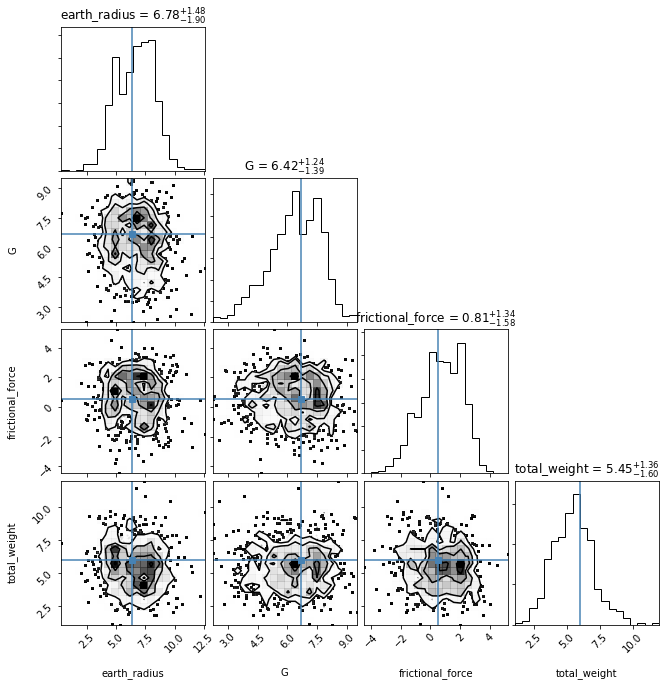

In [232]:
import corner

figure = corner.corner(sampler.flatchain[:],labels=["earth_radius","G","frictional_force", "total_weight"],truths=[6.371,6.67408,0.5, 5.972],show_titles=True)


In [233]:
sampler.reset()
_ = sampler.run_mcmc(pos, 500)

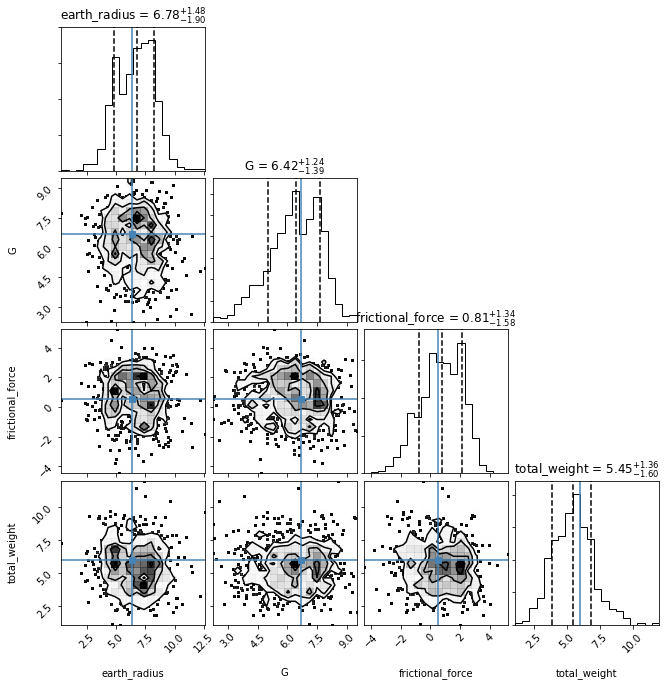

In [234]:
figure = corner.corner(sampler.flatchain[:],labels=["earth_radius","G","frictional_force", "total_weight"],truths=[6.371,6.67408,0.5, 5.972],quantiles=[0.16, 0.5, 0.84],show_titles=True)

The corner plot shows that there are a lot of different peaks in the simulation that could represent my data. This is partially because my simulation is not perfectly accurate (as I could only do a sphere of 20 radius). I originally wanted to do at least a 50 unit radius, but the code took way too long to run. Because my simulation is not accurate, the correct values may not be the true values. 

Another reason is that since there are 4 parameters, not enough data is generated to ensure that the peak detected is the largest. As all 4 parameters are not dependent on each other, increasing one and decreasing the other may generate the same result as increasing the other and decreasing the other. The multiple peaks messes up the average too. Unfortunately, again due to having to run true_value() for every parameter, my computer cannot handle running the number of nsteps necessary. If I had a $10,000 nvidia GPU, I would definately increase the nsteps to maybe 10000. 

In [ ]:
sampler.reset()

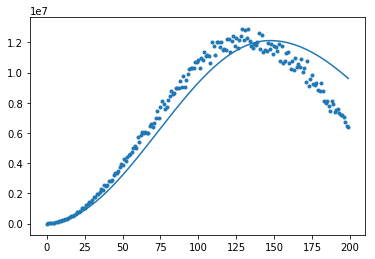

In [237]:
plt.plot(np.linspace(0,199,200), true_value(200, 7.3*10**6, 7.42*10**(-11), 1.81, 5.45*10**24))
plt.scatter(np.linspace(0, 199, 200), d_out[:,1], marker = ".")

To test if the analysis would improve if a larger number of data is inputted, I did the same exact analysis with 400 points, modeling 400* 20 seconds or 2.22 hours of falling. 

In [238]:
import math
earth_d = 6.371 * 10**6*2
pixel_d = earth_d/39
mass = 1
velocity = 0
xpos = 20 * pixel_d
ypos = 0 
zpos = 20 * pixel_d
frictional_force = 0.5 #newtons
g = 6.67408 * 10**(-11) #gravitational constant
length = 400 #length of the run. 400*20 or 4000 seconds. The object will fall little over an hour.
time = np.linspace(0, 399, 400)
simulation400 = np.zeros(length) #recording the data
velocity = 0
ypos = 0
for i in range(0,length):
    for _ in range(0, 20): # every 20 seconds the position is recorded.
        acceleration = 0
        for y in range(len(tdarr[:,0,:])):
            for x in range(len(tdarr[0,:,:])):
                for z in range(len(tdarr[:,:,0])):
                    if (tdarr[x,y,z] != 0):
                        r_2 = (y*pixel_d-ypos)**2+(x*pixel_d-xpos)**2+(z*pixel_d-zpos)**2 #distance squared between point and the object
                        force = g*mass*tdarr[x,y,z]/r_2

                        if (math.sqrt((xpos-x*pixel_d)**2+(z*pixel_d-zpos)**2) ==0): #if the block is the same block the object is on. Don't calculate the force because it is too high.
                            if (y*pixel_d-ypos < pixel_d):
                                acceleration += 0
                            else:
                                acceleration += force/mass
                        else:
                            acceleration +=  np.sin(np.arctan((ypos-y*pixel_d)/math.sqrt((xpos-x*pixel_d)**2+(z*pixel_d-zpos)**2)))*force/mass 
                            #Record only the vertical component of the force.
        print(i, acceleration, velocity)
        velocity -= frictional_force*np.sign(velocity)

        velocity += acceleration
        ypos -= velocity
    simulation400[i] = ypos
#this took me 2 hours to run

0 -8.67437149955116 0
0 -8.786275962356692 -8.67437149955116
0 -8.786301859759304 -16.960647461907854
0 -8.786340407200392 -25.24694932166716
0 -8.786391601899556 -33.53328972886755
0 -8.786455440162666 -41.81968133076711
0 -8.78653191738106 -50.10613677092978
0 -8.786621028028197 -58.39266868831084
0 -8.78672276565879 -66.67928971633904
0 -8.78683712290737 -74.96601248199784
0 -8.786964091483812 -83.25284960490521
0 -8.787103662171237 -91.53981369638902
0 -8.78725582482376 -99.82691735856025
0 -8.7874205683614 -108.11417318338401
0 -8.787597880766137 -116.40159375174541
0 -8.787787749079424 -124.68919163251155
0 -8.787990159395811 -132.97697938159098
0 -8.788205096858293 -141.26496954098678
0 -8.788432545653666 -149.55317463784507
0 -8.788672489007244 -157.84160718349875
1 -8.788924909175257 -166.130279672506
1 -8.789189787440185 -174.41920458168124
1 -8.789467104103915 -182.70839436912144
1 -8.789756838479443 -190.99786147322536
1 -8.790058968884717 -199.2876183117048
1 -8.7903734726

10 -8.942028715199667 -1713.2926197110987
10 -8.941945925305967 -1721.7346484262985
10 -8.941821660741583 -1730.1765943516045
10 -8.94165510426681 -1738.6184160123462
10 -8.941445435605589 -1747.060071116613
10 -8.941191831866554 -1755.5015165522186
10 -8.940893467988577 -1763.942708384085
10 -8.940549517204454 -1772.3836018520738
10 -8.94015915152262 -1780.8241513692783
10 -8.939721542228815 -1789.264310520801
10 -8.939235860411928 -1797.70403206303
10 -8.938701277498057 -1806.1432679234417
10 -8.938116965815732 -1814.5819692009397
10 -8.93748209917077 -1823.0200861667554
10 -8.93679585344643 -1831.457568265926
11 -8.936057407214234 -1839.8943641193725
11 -8.935265942369025 -1848.3304215265869
11 -8.934420644777026 -1856.7656874689558
11 -8.933520704940086 -1865.2001081137328
11 -8.93256531867493 -1873.6336288186728
11 -8.931553687811261 -1882.0661941373478
11 -8.930485020892673 -1890.497747825159
11 -8.929358533901913 -1898.9282328460517
11 -8.928173450985458 -1907.3575913799536
11 -

20 -8.389782906117555 -3342.9705481318506
20 -8.38359589552757 -3350.860331037968
20 -8.377410558963927 -3358.7439269334955
20 -8.371229441951607 -3366.6213374924596
20 -8.365054998390367 -3374.492566934411
20 -8.358889577452455 -3382.3576219328015
20 -8.352735410746648 -3390.216511510254
20 -8.346594599816925 -3398.0692469210007
20 -8.340469104046253 -3405.9158415208176
20 -8.334360729028237 -3413.756310624864
20 -8.328271115472333 -3421.590671353892
20 -8.322201728706865 -3429.4189424693645
20 -8.316153848825728 -3437.241144198071
20 -8.310128561546776 -3445.057298046897
20 -8.304126749826054 -3452.8674266084436
20 -8.298149086268463 -3460.6715533582696
20 -8.292196026388352 -3468.469702444538
21 -8.286267802746032 -3476.2618984709266
21 -8.280364420004796 -3484.0481662736725
21 -8.274485650924952 -3491.8285306936773
21 -8.268631033325779 -3499.603016344602
21 -8.262799868035195 -3507.3716473779277
21 -8.256991217835793 -3515.1344472459627
21 -8.25120390742466 -3522.8914384637987
21 

30 -7.144470935200569 -4793.277008098037
30 -7.1367398579062655 -4799.921479033238
30 -7.128909602391751 -4806.558218891144
30 -7.120970956828904 -4813.187128493536
30 -7.112914994204506 -4819.808099450365
30 -7.104733128476978 -4826.42101444457
30 -7.096417167817851 -4833.025747573047
30 -7.0879593643416 -4839.622164740865
30 -7.079352459695705 -4846.210124105206
30 -7.070589725877141 -4852.789476564902
30 -7.061665000636293 -4859.360066290778
30 -7.052572716812921 -4865.921731291414
30 -7.0433079249677695 -4872.474304008228
30 -7.033866308674492 -4879.017611933195
30 -7.024244191859455 -4885.5514782418695
30 -7.014438537608937 -4892.075722433729
30 -7.004446937890371 -4898.590160971338
30 -6.994267593692006 -4905.094607909228
31 -6.983899285132447 -4911.58887550292
31 -6.973341331155032 -4918.072774788053
31 -6.962593538492647 -4924.546116119208
31 -6.951656139655526 -4931.008709657701
31 -6.940529719780442 -4937.460365797357
31 -6.92921513224581 -4943.900895517137
31 -6.917713403031

40 -5.531669374517145 -5969.971521746973
40 -5.518338913080572 -5975.00319112149
40 -5.5047421503783145 -5980.021530034571
40 -5.4908814895608336 -5985.026272184949
40 -5.476759366798925 -5990.01715367451
40 -5.462377934952517 -5994.9939130413095
40 -5.447738717181278 -5999.956290976262
40 -5.547413632664103 -6004.904029693443
40 -5.536646061492692 -6009.9514433261065
40 -5.525878215843827 -6014.988089387599
40 -5.515126218533728 -6020.013967603442
40 -5.504405604239263 -6025.029093821976
40 -5.493731084577103 -6030.033499426215
40 -5.483116324340432 -6035.027230510792
40 -5.472573732434942 -6040.010346835133
40 -5.462114270743921 -6044.982920567568
40 -5.451747283758888 -6049.945034838312
40 -5.441480351368658 -6054.89678212207
41 -5.431319166736296 -6059.838262473439
41 -5.42126744069494 -6064.769581640175
41 -5.411326833592052 -6069.69084908087
41 -5.401496915039676 -6074.602175914462
41 -5.391775151556755 -6079.503672829502
41 -5.382156921670155 -6084.395447981058
41 -5.37263555765

50 -3.7035202698934166 -6804.406047190628
50 -3.689487380821628 -6807.609567460521
50 -3.6751080199027366 -6810.799054841343
50 -3.6603828795154794 -6813.9741628612455
50 -3.6453141733102385 -6817.134545740761
50 -3.6299052326279733 -6820.279859914071
50 -3.614160033413629 -6823.409765146698
50 -3.598082655808686 -6826.523925180112
50 -3.5816766792857795 -6829.622007835921
50 -3.677123435290176 -6832.703684515207
50 -3.6649175096293027 -6835.880807950497
50 -3.6527076962560274 -6839.045725460126
50 -3.640517905575039 -6842.198433156382
50 -3.6283711153099776 -6845.338951061956
50 -3.6162889269829224 -6848.467322177266
50 -3.6042911482531728 -6851.583611104249
50 -3.5923954095283706 -6854.687902252502
50 -3.580616822250766 -6857.7802976620305
51 -3.568967685102126 -6860.860914484281
51 -3.557457243048984 -6863.929882169384
51 -3.546091502788671 -6866.987339412432
51 -3.5348731067546852 -6870.033430915221
51 -3.523801266504751 -6873.068304021976
51 -3.5128717550399036 -6876.0921052884805

60 -1.7515883385735707 -7247.6107517607215
60 -1.7388418863912536 -7248.862340099295
60 -1.726201925342404 -7250.101181985686
60 -1.7136879941585261 -7251.327383911028
60 -1.7013162714539243 -7252.541071905186
60 -1.689099231032117 -7253.74238817664
60 -1.677045375210364 -7254.931487407672
60 -1.6651590497903759 -7256.108532782882
60 -1.6534403421369832 -7257.273691832673
60 -1.641885061806995 -7258.42713217481
60 -1.630484801349968 -7259.569017236618
60 -1.6192270733201772 -7260.699502037967
60 -1.6080955182474268 -7261.818729111287
60 -1.5970701772823648 -7262.926824629535
60 -1.5861278224770035 -7264.023894806817
60 -1.57524233713399 -7265.110022629294
60 -1.564385138330661 -7266.185264966428
60 -1.55352563353841 -7267.249650104759
60 -1.5426317031863401 -7268.303175738298
60 -1.5316702009766674 -7269.345807441484
61 -1.5206074637677685 -7270.377477642461
61 -1.5094098227967037 -7271.398085106229
61 -1.4980441079598068 -7272.407494929025
61 -1.486478136768439 -7273.405539036985
61 -

69 0.30826877987065254 -7288.653367067358
69 0.3191571612670822 -7287.845098287487
69 0.330081020010413 -7287.0259411262205
69 0.341073800180512 -7286.19586010621
69 0.35216935707267794 -7285.354786306029
70 0.3634014399964663 -7284.5026169489565
70 0.3748031850573735 -7283.63921550896
70 0.3864066263716697 -7282.764412323902
70 0.3982422342431648 -7281.878005697531
70 0.4103384889116787 -7280.979763463288
70 0.42272149855816055 -7280.0694249743765
70 0.4354146702444175 -7279.146703475818
70 0.44843844234964264 -7278.2112888055735
70 0.461810086804752 -7277.262850363224
70 0.4755435889578036 -7276.301040276419
70 0.48964961219526115 -7275.325496687462
70 0.5041355535109467 -7274.335847075266
70 0.5190056950015913 -7273.331711521755
70 0.5342614548568554 -7272.312705826754
70 0.5499017397893188 -7271.2784443718965
70 0.5659233991418495 -7270.228542632107
70 0.5823217791556967 -7269.162619232965
70 0.5990913742400745 -7268.080297453809
70 0.6162265706545479 -7266.981206079569
70 0.633722

79 2.3979085303887486 -6917.37688006161
79 2.4125952034248916 -6914.478971531221
79 2.4276240865161087 -6911.566376327796
79 2.442991526503828 -6908.63875224128
80 2.458692863218962 -6905.695760714776
80 2.474722965384615 -6902.737067851557
80 2.491076830642073 -6899.762344886172
80 2.507750245158191 -6896.7712680555305
80 2.4107093249311817 -6893.763517810372
80 2.4230007796197697 -6890.852808485441
80 2.435275606827975 -6887.929807705821
80 2.44750978199492 -6884.994532098993
80 2.4596805488481532 -6882.047022316998
80 2.471766854113305 -6879.08734176815
80 2.4837497461687312 -6876.115574914036
80 2.4956127300306976 -6873.131825167868
80 2.507342072333419 -6870.136212437837
80 2.5189270514120867 -6867.128870365503
80 2.530360149086029 -6864.109943314091
80 2.541637182210338 -6861.079583165005
80 2.5527573735239537 -6858.037945982795
80 2.5637233626313303 -6854.98518860927
80 2.574541159150744 -6851.921465246639
80 2.585220041083985 -6848.846924087488
81 2.595772402289845 -6845.761704

89 4.322313338949809 -6138.211162495287
90 4.336403388608359 -6133.388849156337
90 4.350745289243484 -6128.552445767728
90 4.365335346744887 -6123.701700478485
90 4.380170497298633 -6118.8363651317395
90 4.281340776435223 -6113.956194634441
90 4.292238914034069 -6109.174853858006
90 4.303122229519046 -6104.382614943972
90 4.31397387375807 -6099.5794927144525
90 4.324777749621162 -6094.765518840694
90 4.335518751125664 -6089.9407410910735
90 4.346182985197243 -6085.105222339947
90 4.356757972728641 -6080.25903935475
90 4.367232826111031 -6075.402281382021
90 4.377598400951285 -6070.53504855591
90 4.387847420281192 -6065.6574501549585
90 4.397974570113035 -6060.769602734677
90 4.407976565795332 -6055.871628164565
90 4.417852189139101 -6050.9636515987695
90 4.427602296802189 -6046.0457994096305
90 4.4372298008637 -6041.118197112828
91 4.4467396229091145 -6036.180967311964
91 4.456138623281164 -6031.234227689055
91 4.465435507407797 -6026.278089065774
91 4.474640711325039 -6021.31265355836

100 5.908220476391041 -4986.186916301032
100 5.91567687947653 -4979.7786958246415
100 5.923116761373566 -4973.363018945165
100 5.930550125419376 -4966.939902183792
100 5.93798720564787 -4960.509352058372
100 5.945438388387522 -4954.071364852724
100 5.952914134364456 -4947.625926464337
100 5.960424901876704 -4941.173012329972
100 5.967981071599619 -4934.7125874280955
100 5.975592873555382 -4928.244606356496
100 5.983270316768606 -4921.76901348294
100 5.991023122107942 -4915.285743166171
100 5.998860658806506 -4908.794720044063
100 6.00679188513092 -4902.295859385256
100 6.01482529366009 -4895.789067500125
100 6.022968861622302 -4889.274242206466
101 6.031230006710809 -4882.751273344844
101 6.039615548791475 -4876.220043338133
101 6.048131677885203 -4869.680427789342
101 6.056783928783734 -4863.1322961114565
101 6.065577162629199 -4856.575512182672
101 6.074515555745985 -4850.0099350200435
101 6.083602595978284 -4843.435419464297
101 6.092841086740717 -4836.8518168683195
101 6.1022331589

110 7.113811959809415 -3580.1742933350106
110 7.120230249036584 -3572.560481375201
110 7.126625752588927 -3564.9402511261646
110 7.1329953092618705 -3557.3136253735756
110 7.139335901020235 -3549.680630064314
110 7.145644666461699 -3542.0412941632935
110 7.151918913162308 -3534.395649496832
110 7.1581561288574385 -3526.7437305836697
110 7.164353991431251 -3519.085574454812
110 7.170510377684257 -3511.421220463381
110 7.1766233708642595 -3503.7507100856965
110 7.182691266963424 -3496.0740867148324
110 7.188712579771961 -3488.391395447869
110 7.1946860447100995 -3480.702682868097
110 7.200610621451325 -3473.0079968233867
110 7.206485495367123 -3465.3073862019355
110 7.212310077823505 -3457.6009007065686
111 7.21808400536888 -3449.888590628745
111 7.2238071378573965 -3442.1705066233762
111 7.22947955555769 -3434.446699485519
111 7.235101555298394 -3426.717219929961
111 7.240673645707122 -3418.9821183746626
111 7.246196541601171 -3411.2414447289557
111 7.2516711575916455 -3403.495248187354

120 7.960174673260046 -1979.9792847907331
120 7.963871555397138 -1971.519110117473
120 7.967578939116962 -1963.0552385620758
120 7.971296717893775 -1954.5876596229589
120 7.975024762967206 -1946.1163629050652
120 7.978762924194416 -1937.641338142098
120 7.9825110309166165 -1929.1625752179036
120 7.986268892839565 -1920.680064186987
120 7.990036300929438 -1912.1937952941475
120 7.9938130283143956 -1903.7037589932181
120 7.997598831197852 -1895.2099459649037
120 8.001393449774838 -1886.7123471337059
120 8.005196609151026 -1878.210953683931
120 8.00900802026575 -1869.70575707478
120 8.012827380811268 -1861.1967490545142
120 8.01665437615083 -1852.6839216737028
120 8.020488680231372 -1844.167267297552
120 8.02432995649091 -1835.6467786173205
120 8.028177858754324 -1827.1224486608296
121 8.032032032123347 -1818.5942708020752
121 8.035892113851034 -1810.0622387699518
121 8.039757734205262 -1801.5263466561007
121 8.04362851731711 -1792.9865889218954
121 8.047504082011182 -1784.4429604045783
1

130 8.266316791360957 -258.49689922698474
130 8.266693279962428 -249.73058243562377
130 8.267056490732278 -240.96388915566135
130 8.267406430669975 -232.19683266492908
130 8.267743106346021 -223.4294262342591
130 8.268066523921172 -214.66168312791308
130 8.26837668916491 -205.89361660399192
130 8.26867360747207 -197.125239914827
130 8.268957283880694 -188.35656630735494
130 8.26922772308731 -179.58760902347424
130 8.269484929463532 -170.81838130038693
130 8.26972890707042 -162.0488963709234
130 8.269959659673264 -153.27916746385296
130 8.270177190754893 -144.50920780417968
130 8.270381503528464 -135.7390306134248
130 8.270572600950665 -126.96864910989633
130 8.270750485731016 -118.19807650894566
130 8.270915160346705 -109.42732602321465
130 8.27106662704794 -100.65641086286794
130 8.27120488787125 -91.88534423582
131 8.271329944645647 -83.11413934794875
131 8.271441799002357 -74.34280940330311
131 8.271540452380624 -65.57136760430075
131 8.271625906034897 -56.79982715192013
131 8.27169

140 8.076084177764363 1346.0202254773199
140 8.073646478125465 1353.5963096550843
140 8.071193422817776 1361.1699561332098
140 8.068725171011293 1368.7411495560275
140 8.066241889794467 1376.3098747270387
140 8.063743754217397 1383.876116616833
140 8.061230947321457 1391.4398603710504
140 8.058703660160733 1399.001091318372
140 8.056162091810227 1406.5597949785326
140 8.053606449361155 1414.1159570703428
140 8.051036947906114 1421.6695635197038
140 8.048453810509299 1429.22060046761
140 8.045857268163099 1436.7690542781193
140 8.043247559732432 1444.3149115462822
140 8.040624931883377 1451.8581591060147
140 8.149040233523776 1459.3987840378982
141 8.145405426065997 1467.0478242714219
141 8.14176634362277 1474.6932296974878
141 8.138123237319771 1482.3349960411106
141 8.13447636449441 1489.9731192784304
141 8.130825988570518 1497.607595642925
141 8.127172378916812 1505.2384216314954
141 8.12351581068453 1512.8655940104122
141 8.119856564629531 1520.4891098210967
141 8.11619492691305 152

150 7.503197252036724 2829.402265294883
150 7.49774472922851 2836.40546254692
150 7.492335477526462 2843.4032072761484
150 7.48696925371483 2850.395542753675
150 7.481645726818658 2857.38251200739
150 7.476364476107335 2864.364157734208
150 7.471124989411392 2871.3405222103156
150 7.465926661760612 2878.311647199727
150 7.46076879435144 2885.2775738614873
150 7.455650593846005 2892.2383426558386
150 7.4505711720102346 2899.1939932496844
150 7.445529545696486 2906.1445644216947
150 7.440524637169349 2913.090093967391
150 7.435555274782823 2920.0306186045605
151 7.430620194004436 2926.9661738793434
151 7.4257180387918496 2933.896794073348
151 7.420847363320061 2940.8225121121395
151 7.416006634056629 2947.74335947546
151 7.411194232184979 2954.659366109516
151 7.406408456375536 2961.5705603417014
151 7.4016475258937025 2968.476968798077
151 7.396909584051871 2975.3786163239706
151 7.392192701988302 2982.2755259080227
151 7.387494882777443 2989.167718610011
151 7.382814065859945 2996.0552

160 6.4563558895431 4150.73143137313
160 6.449818903207532 4156.687787262674
160 6.443331370675397 4162.637606165881
160 6.436887419811984 4168.580937536556
160 6.4304810260235 4174.517824956368
160 6.424106041193408 4180.4483059823915
160 6.4177562239196595 4186.372412023585
160 6.411425270905044 4192.290168247504
160 6.405106849342815 4198.201593518409
160 6.398794630141303 4204.106700367752
160 6.392482321812165 4210.005494997893
161 6.386163704856137 4215.897977319705
161 6.379832666458095 4221.784141024561
161 6.373483235309357 4227.663973691019
161 6.367109616353437 4233.537456926329
161 6.360706225257748 4239.404566542682
161 6.354267722397991 4245.26527276794
161 6.347789046131775 4251.119540490337
161 6.341265445139278 4256.967329536469
161 6.33469250959563 4262.808594981609
161 6.328066200937357 4268.643287491204
161 6.321382879978632 4274.471353692142
161 6.314639333133552 4280.292736572121
161 6.307832796495403 4286.107375905254
161 6.300960977531316 4291.915208701749
161 6

170 5.070656136071211 5236.480488380058
170 5.062187374056364 5241.051144516129
170 5.053830047979473 5245.613331890186
170 5.045573021263236 5250.167161938165
170 5.037404665612835 5254.712734959428
170 5.029312946369823 5259.250139625041
171 5.021285513200302 5263.779452571411
171 5.013309795301493 5268.300738084611
171 5.005373100315258 5272.814047879912
171 4.997462716111763 5277.319420980228
171 4.989566014608064 5281.81688369634
171 4.981670556746313 5286.306449710948
171 4.973764197765401 5290.7881202676945
171 4.965835191852428 5295.26188446546
171 4.957872295255711 5299.727719657312
171 4.949864866909813 5304.185591952568
171 4.941802965594348 5308.635456819477
171 4.9336774426488486 5313.077259785072
171 4.925480029218241 5317.510937227721
171 4.917203417029079 5321.936417256939
171 4.908841331672371 5326.353620673968
171 4.900388597394187 5330.76246200564
171 4.8918411924167575 5335.162850603035
171 4.883196293865594 5339.554691795452
171 4.874452311426716 5343.937888089317


180 3.3930881221976 6005.344284232723
180 3.3824562942382257 6008.237372354921
181 3.3717756850535707 6011.119828649159
181 3.361061419502645 6013.991604334213
181 3.3503293923037885 6016.852665753715
181 3.451074752256506 6019.702995146019
181 3.43636473464475 6022.654069898275
181 3.4218955453201634 6025.59043463292
181 3.407669495570859 6028.51233017824
181 3.393689651477006 6031.419999673811
181 3.3799594766808565 6034.313689325288
181 3.366482499310005 6037.193648801968
181 3.353262004980081 6040.0601313012785
181 3.340300757723142 6042.9133933062585
181 3.3276007505122958 6045.753694063982
181 3.3151629867729246 6048.581294814494
181 3.3029872939538225 6051.3964578012665
181 3.2910721698455307 6054.199445095221
181 3.279414661941512 6056.990517265066
181 3.2680102797327457 6059.769931927008
181 3.2568529394345442 6062.537942206741
181 3.245934940274646 6065.294795146176
182 3.2352469711426988 6068.04073008645
182 3.224778146102365 6070.775977057592
182 3.214516067023725 6073.5007

191 1.590055616488335 6417.561858447623
191 1.57930972518161 6418.651914064111
191 1.568435719855138 6419.731223789293
191 1.5574407021593464 6420.799659509148
191 1.546334168660412 6421.857100211308
191 1.535127857478804 6422.903434379968
191 1.523835557138741 6423.938562237447
191 1.5124728801141019 6424.962397794586
191 1.5010570044060718 6425.9748706747
191 1.4896063872717087 6426.975927679106
191 1.478140455953273 6427.965534066378
191 1.5774021791831048 6428.943674522331
191 1.5617546258865518 6430.021076701514
191 1.546387489393083 6431.0828313274005
191 1.5313035720187476 6432.129218816794
191 1.5165064975675155 6433.160522388813
191 1.5020002273065767 6434.17702888638
191 1.4877886150591562 6435.179029113687
191 1.4738750040903292 6436.166817728746
192 1.4602618682402586 6437.140692732836
192 1.4469504993409807 6438.100954601076
192 1.4339407424391106 6439.047905100418
192 1.4212307797338168 6439.981845842857
192 1.408816963479972 6440.903076622591
192 1.396693697452723 6441.8

201 -0.2486622978050615 6455.9054087136055
201 -0.2590606343906037 6455.156746415801
201 -0.2695914886928171 6454.3976857814105
201 -0.28025558566865605 6453.628094292718
201 -0.29105097317526524 6452.847838707049
201 -0.30197306097855514 6452.0567877338735
201 -0.3130147010220437 6451.254814672895
201 -0.3241663087673808 6450.441799971873
201 -0.33541602460290526 6449.617633663105
201 -0.34674991344518347 6448.7822176385025
201 -0.3581521997969338 6447.935467725058
201 -0.3696055346676879 6447.077315525261
201 -0.3810912899744887 6446.207709990594
201 -0.39258987533112005 6445.326618700619
201 -0.2932142486722783 6444.434028825288
201 -0.3089058770197119 6443.640814576615
201 -0.3243115319744674 6442.831908699595
201 -0.33942867826836537 6442.007597167621
201 -0.35425394391648024 6441.168168489352
201 -0.3687836108110245 6440.313914545435
202 -0.38301406389747045 6439.445130934624
202 -0.39694219648651463 6438.562116870727
202 -0.4105657694925771 6437.66517467424
202 -0.42388372282057

210 -2.0177759254271503 6137.476152015298
210 -2.0269527681721384 6134.95837608987
210 -2.036113998620954 6132.431423321698
210 -2.0452785788635874 6129.8953093230775
211 -2.0544645791452347 6127.350030744214
211 -2.0636889767160214 6124.7955661650685
211 -2.0729674654468613 6122.231877188353
211 -2.0823142786219178 6119.658909722906
211 -2.091742027277889 6117.076595444284
211 -2.1012615564003627 6114.484853417006
211 -2.110881821192429 6111.8835918606055
211 -2.120609785511624 6109.272710039413
211 -2.130450344389254 6106.652100253901
211 -2.1404062723301807 6104.021649909512
211 -2.1504781988100983 6101.381243637182
211 -2.160664612049796 6098.730765438372
211 -2.170961891763858 6096.070100826322
211 -2.181364371137074 6093.399138934558
211 -2.191864427792613 6090.717774563422
211 -2.2024526030157108 6088.025910135629
211 -2.2131177479446453 6085.323457532613
211 -2.2238471949114462 6082.610339784668
211 -2.234626951586667 6079.886492589757
211 -2.245441915085502 6077.15186563817
21

220 -3.610451333697358 5474.039299124158
220 -3.6231601551688266 5469.92884779046
220 -3.635649303017888 5465.805687635291
220 -3.6479168894548586 5461.670038332273
220 -3.6599611625799096 5457.522121442818
220 -3.6717806777849717 5453.362160280239
221 -3.683374450320479 5449.1903796024535
221 -3.6947420887175317 5445.007005152133
221 -3.705883908908936 5440.812263063416
221 -3.7168010290648126 5436.6063791545075
221 -3.727495445326593 5432.389578125442
221 -3.7379700887960325 5428.162082680115
221 -3.748228864309237 5423.9241125913195
221 -3.7582766716660645 5419.67588372701
221 -3.7681194101364945 5415.417607055344
221 -3.7777639671761225 5411.149487645207
221 -3.787218192382252 5406.871723678031
221 -3.7964908578060883 5402.584505485649
221 -3.8055916057856805 5398.288014627843
221 -3.8145308855066413 5393.982423022057
221 -3.823319879519568 5389.667892136551
221 -3.8319704214413908 5385.344572257031
221 -3.8404949060669615 5381.0126018355895
221 -3.848906193092264 5376.672106929523

230 -5.064664589891959 4493.639807131473
230 -5.074452556333554 4488.075142541581
230 -5.0840820762410415 4482.500689985248
230 -5.093553042320644 4476.916607909006
230 -5.10286564657313 4471.323054866686
230 -5.112020418293829 4465.720189220113
231 -5.121018255798457 4460.108168801819
231 -5.12986045200768 4454.4871505460205
231 -5.138548714057964 4448.857290094013
231 -5.147085177133934 4443.218741379955
231 -5.1554724127566285 4437.571656202821
231 -5.163713431778905 4431.916183790065
231 -5.17181168236881 4426.252470358286
231 -5.179771043277553 4420.580658675917
231 -5.187595812707443 4414.90088763264
231 -5.195290693101997 4409.213291819932
231 -5.202860772193873 4403.51800112683
231 -5.210311500645372 4397.815140354636
231 -5.217648666620874 4392.1048288539905
231 -5.224878367628492 4386.387180187369
231 -5.232006979960336 4380.662301819741
231 -5.239041126061713 4374.93029483978
231 -5.245987640141316 4369.191253713718
231 -5.25285353233611 4363.445266073576
231 -5.259645951724

240 -6.225076009081609 3263.048669246191
240 -6.23003217774491 3256.3235932371094
240 -6.23496340422449 3249.5935610593647
240 -6.239872759540248 3242.8585976551403
240 -6.2447632543101355 3236.1187248956003
240 -6.249637830417281 3229.37396164129
240 -6.2544993529876844 3222.6243238108727
241 -6.259350602714754 3215.869824457885
241 -6.264194268542153 3209.1104738551703
241 -6.269032940728497 3202.346279586628
241 -6.273869104310529 3195.5772466458993
241 -6.278705132981659 3188.803377541589
241 -6.283543283400561 3182.0246724086073
241 -6.288385689942181 3175.241129125207
241 -6.293234359908397 3168.452743435265
241 -6.2980911692020785 3161.6595090753567
241 -6.302957858481018 3154.8614179061547
241 -6.307836029794975 3148.0584600476736
241 -6.312727143715974 3141.2506240178786
241 -6.317632516964769 3134.4378968741626
241 -6.322553320541075 3127.620264357198
241 -6.327490578353417 3120.797711036657
241 -6.332445166357883 3113.9702204583036
241 -6.337417812198708 3107.1377752919457
2

250 -6.895652080315811 1860.1332659439206
250 -6.900096051295989 1852.7376138636048
250 -6.904498832534553 1845.3375178123088
250 -6.908860616081041 1837.9330189797743
250 -6.913181591124033 1830.5241583636932
250 -6.9174619450252575 1823.1109767725693
250 -6.9217018642810615 1815.693514827544
250 -6.92590153540495 1808.271812963263
250 -6.930061145738425 1800.845911427858
250 -6.9341808841943795 1793.4158502821197
251 -6.9382609419333265 1785.9816693979253
251 -6.942301512974469 1778.543408455992
251 -6.946302794747549 1771.1011069430176
251 -6.950264988583578 1763.6548041482702
251 -6.954188300153001 1756.2045391596866
251 -6.958072939846975 1748.7503508595337
251 -6.961919123110377 1741.2922779196867
251 -6.965727070724362 1733.8303587965763
251 -6.969497009043206 1726.364631725852
251 -6.973229170188441 1718.8951347168088
251 -6.976923792200554 1711.4219055466203
251 -6.980581119152374 1703.9449817544198
251 -6.984201401223005 1696.4644006352673
251 -6.987784894740362 1688.98019923

260 -7.289025149140191 345.49572800417053
260 -7.289575141940398 337.70670285503036
260 -7.290112788691818 329.91712771308994
260 -7.290638065579291 322.1270149243981
260 -7.2911509492270445 314.3363768588188
260 -7.291651416713729 306.5452259095918
260 -7.292139445579239 298.7535744928781
260 -7.29261501383755 290.96143504729883
260 -7.2930780999852 283.16882003346126
260 -7.293528683011578 275.37574193347604
260 -7.2939667424057175 267.58221325046446
260 -7.294392258165798 259.78824650805876
261 -7.294805210806593 251.99385424989296
261 -7.295205581366473 244.19904903908636
261 -7.29559335141504 236.4038434577199
261 -7.295968503057716 228.60825010630484
261 -7.296331018943905 220.81228160324713
261 -7.296680882270999 213.01595058430323
261 -7.297018076791399 205.21926970203222
261 -7.29734258681587 197.42225162524082
261 -7.297654397219466 189.62490903842496
261 -7.29795349344442 181.82725464120549
261 -7.298239861506583 174.02930114776106
261 -7.298513487996479 166.2310612862545
26

270 -7.179652807629808 -1019.3951175075279
270 -7.17806502394866 -1026.0747703151576
270 -7.176465219458596 -1032.7528353391062
270 -7.174853266026469 -1039.4293005585648
270 -7.173229031502934 -1046.1041538245913
270 -7.171592379693581 -1052.7773828560942
270 -7.1699431703311 -1059.4489752357877
270 -7.1682812590491976 -1066.1189184061188
270 -7.166606497362267 -1072.7871996651681
270 -7.164918732645534 -1079.4538061625303
270 -7.163217808120027 -1086.1187248951758
270 -7.161503562837237 -1092.7819427032957
270 -7.159775831672455 -1099.443446266133
270 -7.158034445316391 -1106.1032220978054
270 -7.156279230274734 -1112.7612565431218
270 -7.154510008866811 -1119.4175357733966
270 -7.152726599231729 -1126.0720457822633
271 -7.150928815336942 -1132.724772381495
271 -7.149116466989967 -1139.375701196832
271 -7.147289359856765 -1146.024817663822
271 -7.145447295480039 -1152.6721070236788
271 -7.143590071306899 -1159.3175543191587
271 -7.141717480717117 -1165.9611443904655
271 -7.1398293130

279 -6.7165150361962445 -2261.467124208366
279 -6.713064967455003 -2267.683639244562
279 -6.709600978397383 -2273.896704212017
279 -6.706122013863309 -2280.1063051904143
279 -6.7026269959568205 -2286.312427204278
280 -6.699114825363762 -2292.5150542002348
280 -6.695584382740926 -2298.7141690255985
280 -6.692034530158285 -2304.9097534083394
280 -6.688464112605649 -2311.1017879384976
280 -6.684871959553819 -2317.2902520511034
280 -6.68125688657283 -2323.475124010657
280 -6.677617697002767 -2329.65638089723
280 -6.673953183674014 -2335.833998594233
280 -6.670262130678203 -2342.007951777907
280 -6.666543315180672 -2348.178213908585
280 -6.662795509276862 -2354.3447572237656
280 -6.659017481886259 -2360.5075527330423
280 -6.655208000680064 -2366.6665702149285
280 -6.6513658340399395 -2372.8217782156084
280 -6.647489753042943 -2378.9731440496485
280 -6.643578533465502 -2385.1206338026914
280 -6.639630957806279 -2391.264212336157
280 -6.6356458173189 -2397.4038432939633
280 -6.63162191404907 

289 -5.937728309455588 -3387.9093489439815
289 -5.931860857052157 -3393.347077253437
289 -5.9260162420705145 -3398.778938110489
289 -5.920195969679231 -3404.2049543525595
289 -5.91440136874276 -3409.625150322239
289 -5.908633583439799 -3415.0395516909816
289 -5.902893565632201 -3420.4481852744216
289 -5.89718206802811 -3425.8510788400536
289 -5.89149963816843 -3431.2482609080816
289 -5.885846613263054 -3436.6397605462503
289 -5.880223115902953 -3442.025607159513
289 -5.874629050670565 -3447.405830275416
290 -5.869064101651324 -3452.7804593260867
290 -5.863527730869989 -3458.149523427738
290 -5.858019177648712 -3463.513051158608
290 -5.852537458890274 -3468.8710703362567
290 -5.847081370285014 -3474.223607795147
290 -5.841649488434245 -3479.570689165432
290 -5.836240173878425 -3484.9123386538663
290 -5.830851575020574 -3490.248578827745
290 -5.825481632922259 -3495.5794304027654
290 -5.8201280869559655 -3500.9049120356876
290 -5.814788481291834 -3506.225040122644
290 -5.809460172188989 

299 -4.838704848827019 -4338.196498894494
299 -4.8321972661489365 -4342.53520374332
299 -4.825671564734649 -4346.867401009469
299 -4.819120645043102 -4351.193072574204
299 -4.8125372760319545 -4355.512193219247
299 -4.805914133894464 -4359.824730495279
299 -4.799243841319311 -4364.130644629174
299 -4.792519007047103 -4368.429888470493
299 -4.785732265482711 -4372.72240747754
299 -4.778876316120516 -4377.008139743023
299 -4.771943962527033 -4381.287016059144
299 -4.764928150620814 -4385.558960021671
299 -4.757822005973346 -4389.823888172292
299 -4.7506188698556 -4394.081710178265
299 -4.743312333737687 -4398.33232904812
299 -4.735896271943966 -4402.575641381858
299 -4.728364872161209 -4406.811537653802
299 -4.7207126634888095 -4411.039902525963
300 -4.712934541713138 -4415.2606151894515
300 -4.705025791494362 -4419.473549731165
300 -4.696982105145022 -4423.678575522659
300 -4.688799597689203 -4427.8755576278045
300 -4.6804748178922235 -4432.064357225494
300 -4.672004754965682 -4436.2448

308 -3.5237026143899683 -5057.5251256288475
308 -3.51564593103483 -5060.548828243237
308 -3.507661345065627 -5063.564474174272
309 -3.4997450716114638 -5066.572135519337
309 -3.4918923721645645 -5069.571880590949
309 -3.484097589619853 -5072.5637729631135
309 -3.4763541908912585 -5075.547870552733
309 -3.4686548166007114 -5078.5242247436245
309 -3.4609913372863303 -5081.492879560225
309 -3.4533549155601775 -5084.4538708975115
309 -3.445736073611712 -5087.407225813072
309 -3.4381247654393627 -5090.352961886683
309 -3.430510453179248 -5093.291086652122
309 -3.422882186888565 -5096.221597105302
309 -3.415228687128007 -5099.14447929219
309 -3.4075384296844122 -5102.059707979318
309 -3.3997997317583986 -5104.967246409003
309 -3.3920008389365837 -5107.867046140761
309 -3.384130012249639 -5110.759046979698
309 -3.3761756146094886 -5113.643176991947
309 -3.368126195895584 -5116.519352606557
309 -3.3599705759473175 -5119.387478802452
309 -3.3516979247009364 -5122.247449378399
310 -3.34329783868

318 -2.052213022628166 -5499.602599956142
318 -2.0439715379315255 -5501.15481297877
318 -2.0357460608970506 -5502.698784516701
318 -2.02752345186828 -5504.234530577598
318 -2.0192900048577727 -5505.7620540294665
318 -2.0110315700910784 -5507.281344034324
318 -2.002733679530992 -5508.792375604416
318 -1.9943816742122809 -5510.295109283947
318 -1.985960832207946 -5511.789490958159
318 -1.977456496039651 -5513.275451790367
319 -1.9688541983234797 -5514.752908286407
319 -1.9601397844300241 -5516.22176248473
319 -1.9512995309122114 -5517.68190226916
319 -1.9423202584317416 -5519.133201800072
319 -1.9331894378980294 -5520.575522058504
319 -1.92389528851013 -5522.008711496403
319 -1.9144268663832418 -5523.432606784912
319 -1.9047741424413178 -5524.8470336512955
319 -1.894928068260839 -5526.251807793737
319 -1.8848806285848136 -5527.6467358619975
319 -1.874624879263095 -5529.031616490583
319 -1.8641549694429764 -5530.406241369846
319 -1.853466146919007 -5531.770396339289
319 -1.842554745663988

328 -0.49882988932409145 -5649.506032840961
328 -0.48872067547118425 -5649.504862730285
328 -0.47840187350814095 -5649.493583405756
328 -0.46786653098477576 -5649.471985279264
328 -0.4571089005593027 -5649.439851810249
328 -0.44612443746709485 -5649.396960710808
328 -0.4349097764890743 -5649.343085148275
328 -0.4234626876018131 -5649.277994924764
328 -0.4117820096803505 -5649.201457612366
328 -0.3998675618439047 -5649.113239622046
328 -0.3877200322520018 -5649.0131071838905
328 -0.37534084441018817 -5648.900827216143
328 -0.3627320012546649 -5648.776168060553
328 -0.3498959075259025 -5648.638900061807
328 -0.3368351711286201 -5648.488795969333
328 -0.3235523843519371 -5648.325631140462
328 -0.3100498859352519 -5648.149183524814
328 -0.2963295050411242 -5647.959233410749
329 -0.396276726711 -5647.7555629157905
329 -0.3862008680850569 -5647.651839642502
329 -0.37612942836227586 -5647.538040510587
329 -0.36607583291138934 -5647.414169938949
329 -0.35605303936984845 -5647.280245771861
329 

337 1.1046799672838796 -5501.951071387067
337 1.00511193671678 -5500.346391419783
337 1.0149201596240287 -5498.841279483066
337 1.0247245895605348 -5497.3263593234415
337 1.0345127689117792 -5495.801634733881
337 1.04427263961879 -5494.267121964969
338 1.0539926909304245 -5492.722849325351
338 1.0636620997297774 -5491.16885663442
338 1.0732708616332816 -5489.60519453469
338 1.0828099112506717 -5488.031923673057
338 1.0922712301899058 -5486.449113761806
338 1.101647941628755 -5484.856842531616
338 1.11093439051028 -5483.255194589988
338 1.1201262086656991 -5481.644260199478
338 1.1292203644176109 -5480.024133990812
338 1.1382151964543454 -5478.394913626394
338 1.147110431996093 -5476.756698429939
338 1.1559071894864632 -5475.109587997943
338 1.164607966233997 -5473.453680808457
338 1.1732166116003695 -5471.789072842223
338 1.1817382864801538 -5470.115856230622
338 1.1901794099349403 -5468.434117944142
338 1.1985475939483872 -5466.743938534207
338 1.2068515673383455 -5465.045390940259
33

347 2.5108912078481627 -5050.971815020937
347 2.519389016776873 -5047.960923813089
347 2.527802244947176 -5044.941534796312
347 2.5361291660554572 -5041.913732551365
347 2.5443690476727174 -5038.877603385309
347 2.552522155364149 -5035.833234337636
347 2.560589747497194 -5032.780712182272
347 2.568574061062952 -5029.720122434775
347 2.5764782889427247 -5026.651548373711
348 2.584306549097946 -5023.575070084768
348 2.592063846227337 -5020.49076353567
348 2.5997560264812445 -5017.398699689443
348 2.607389725847456 -5014.298943662961
348 2.614972312857282 -5011.191553937114
348 2.6225118262647453 -5008.0765816242565
348 2.6300169083664415 -5004.954069797992
348 2.637496734622029 -5001.824052889626
348 2.644960940236819 -4998.686556155004
348 2.6524195443577336 -4995.541595214767
348 2.659882872521364 -4992.389175670409
348 2.667361477983922 -4989.229292797888
348 2.674866062548334 -4986.061931319904
348 2.6824073974958096 -4982.887065257356
348 2.6899962452123045 -4979.70465785986
348 2.6

357 3.8287661564701025 -4315.683279527275
357 3.8364495111897132 -4311.354513370805
357 3.844112771167048 -4307.018063859615
357 3.851750263668296 -4302.673951088448
357 3.859356566429673 -4298.322200824779
357 3.866926546585795 -4293.96284425835
357 3.8744553969580786 -4289.595917711764
357 3.8819386694509324 -4285.221462314806
357 3.889372305339949 -4280.839523645354
357 3.8967526622653965 -4276.450151340015
357 3.9040765377975517 -4272.053398677749
358 3.91134118945748 -4267.649322139951
358 3.9185443511306857 -4263.237980950494
358 3.9256842458347077 -4258.819436599363
358 3.932759594845988 -4254.393752353529
358 3.93976962321654 -4249.960992758683
358 3.9467140617443683 -4245.521223135466
358 3.953593145490535 -4241.074509073722
358 3.9604076089585694 -4236.620915928232
358 3.9671586780718515 -4232.1605083192735
358 3.973848059113231 -4227.693349641202
358 3.980477924793302 -4223.219501582089
358 3.9870508976402035 -4218.739023657296
358 3.9935700309020956 -4214.2519727596555
358 

367 4.943807777348127 -3340.1087151755705
367 4.948869749963716 -3334.6649073982226
367 4.953904170421255 -3329.216037648259
367 4.958913493906647 -3323.762133477838
367 4.963900274910969 -3318.3032199839313
367 4.968867156845415 -3312.8393197090204
367 4.973816861548699 -3307.370452552175
367 4.978752178733141 -3301.896635690626
367 4.983675955406082 -3296.4178835118933
367 4.988591085312404 -3290.9342075564873
367 4.99350049842971 -3285.445616471175
367 4.9984071505552405 -3279.9521159727456
367 5.00331401301882 -3274.4537088221905
368 5.0082240625561205 -3268.9503948091715
368 5.013140271369495 -3263.4421707466154
368 5.018065597410634 -3257.929030475246
368 5.023002974909623 -3252.4109648778353
368 5.027955305183248 -3246.887961902926
368 5.0329254477387915 -3241.3600065977425
368 5.037916211709561 -3235.827081150004
368 5.042930347634578 -3230.289164938294
368 5.047970539612516 -3224.7462345906597
368 5.053039397845708 -3219.1982640510473
368 5.058139451596429 -3213.6452246532017


377 5.704777948515195 -2176.5188034880102
377 5.708649105095693 -2170.314025539495
377 5.712506006873167 -2164.105376434399
377 5.716347948516611 -2157.892870427526
377 5.720174249615741 -2151.6765224790092
377 5.723984255577878 -2145.4563482293934
377 5.727777338445672 -2139.2323639738156
377 5.7315528976330326 -2133.00458663537
377 5.735310360582285 -2126.773033737737
377 5.739049183345085 -2120.5377233771546
377 5.742768851080295 -2114.2986741938093
377 5.746468878478094 -2108.055905342729
377 5.750148810107257 -2101.809436464251
377 5.753808220687672 -2095.5592876541436
377 5.75744671529049 -2089.305479433456
378 5.761063929467884 -2083.048032718166
378 5.764659529311501 -2076.786968788698
378 5.7682332114464305 -2070.5223092593865
378 5.771784702957233 -2064.25407604794
378 5.775313761255252 -2057.982291344983
378 5.77882017388083 -2051.7069775837276
378 5.782303758251534 -2045.4281574098468
378 5.785764361352561 -2039.1458536515952
378 5.789201859376303 -2032.8600892902427
378 5.

387 6.238643868582154 -897.6525459642093
387 6.2407931279239035 -890.9139020956271
387 6.24293150100768 -884.1731089677032
387 6.245058855021888 -877.4301774666956
387 6.247175058784308 -870.6851186116737
387 6.249279982726394 -863.9379435528895
387 6.251373498878312 -857.188663570163
387 6.253455480849289 -850.4372900712847
387 6.255525803810666 -843.6838345904354
387 6.257584344474436 -836.9283087866247
387 6.25963098107398 -830.1707244421502
387 6.149544761701937 -823.4110934610762
387 6.151004239188884 -816.7615486993743
387 6.152452120893957 -810.1105444601855
387 6.153888356855347 -803.4580923392915
387 6.15531289920837 -796.8042039824362
387 6.156725702150624 -790.1488910832278
387 6.158126721910308 -783.4921653810771
388 6.159515916709437 -776.8340386591668
388 6.160893246731183 -770.1745227424574
388 6.162258674081973 -763.5136294957261
388 6.163612162755583 -756.8513708216442
388 6.164953678597215 -750.1877586588886
388 6.1662831892645835 -743.5228049802913
388 6.167600664191

397 6.215453963299048 385.73879620525236
397 6.214766703010866 391.4542501685514
397 6.214069089663927 397.1690168715623
397 6.213361114148454 402.88308596122624
397 6.212642767512867 408.59644707537467
397 6.211914040975878 414.30908984288754
397 6.211174925945041 420.02100388386344
397 6.21042541403027 425.7321788098085
397 6.209665497059351 431.44260422383877
397 6.208895167096559 437.1522697208981
397 6.208114416456331 442.8611648879947
397 6.207323237722666 448.569279304451
397 6.206521623764935 454.2766025421737
397 6.205709567756678 459.98312416593865
397 6.204887063193116 465.68883373369533
397 6.2040541039092245 471.39372079688843
397 6.203210684100105 477.0977749007977
398 6.202356798336891 482.8009855848978
398 6.201492441591006 488.50334238323467
398 6.200617609248834 494.2048348248257
398 6.1997322971361895 499.9054524340745
398 6.198836501535914 505.60518473121067
398 6.197930219210639 511.3040212327466
398 6.1970134474224645 517.0019514519572
398 6.1960861839558925 522.6

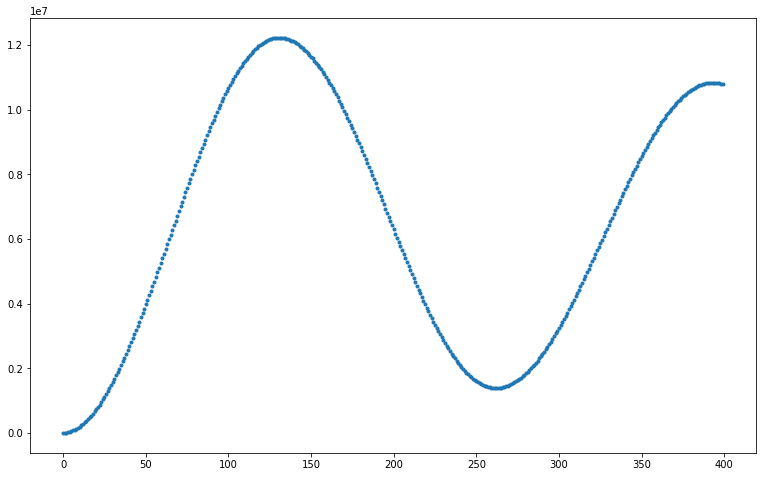

In [242]:
plt.figure(figsize=(13,8))
plt.scatter(time, simulation400, marker =".")

In [243]:
noisy400 = np.zeros(len(simulation400))
for i in range(0, len(simulation400)):
    
    sigma = simulation400[i] /30
    noise = np.random.normal(mu, sigma)
    noisy400[i] = simulation400[i] + noise

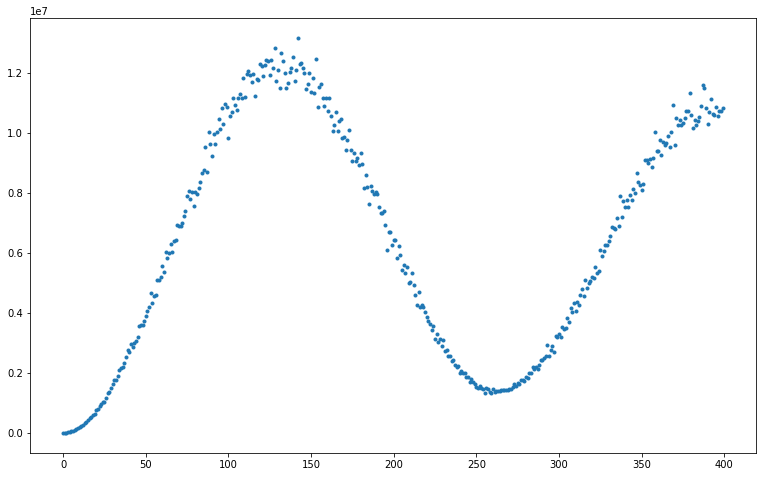

In [244]:
plt.figure(figsize=(13,8))
plt.scatter(time, noisy400, marker =".")

In [251]:
def chi_squared400(parameters_guess, data):
    #t_array = np.linspace(0, length-1, length)
    length = 400 #length changed to 400
    earth_r, G, frictional_force, total_weight = parameters_guess
    t_array = data[:,0]
    x_experiment = data[:,1]
    
    if earth_r<5 or earth_r>8:
       # print("er", earth_r)
        return np.inf
    if (G < 4.5 or G > 7.5):
     #   print("g", G)
        return np.inf
    if (frictional_force < -1 or frictional_force > 2):
    #    print("ff", frictional_force)
        return np.inf
    if (total_weight < 4 or total_weight > 8):
       # print("tw", total_weight)
        return np.inf
    
    x_guess = true_value(length, earth_r* 10**6, G* 10**(-11), frictional_force, total_weight*10**24)
    chi_squared = np.power((x_guess - x_experiment),2)/(0.04)
    #print("chisq", np.sum(chi_squared))
    return np.sum(chi_squared)

In [252]:
length_g = 200
earth_r_g = 6
G_g = 6
frictional_force_g = 0.3
total_weight_g = 5
nwalkers = 1000
ndim = 4
d_out = np.vstack((np.linspace(0,399,400)*20,noisy400)).transpose()
parameters = [0,0,0,0]

sampler = emcee.EnsembleSampler(nwalkers, ndim, chi_squared400, args=[d_out])
p0 = [earth_r_g, G_g, frictional_force_g, total_weight_g]+np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
print(p0)

[[6.47159988 6.3931004  0.48489186 5.4732259 ]
 [6.90760754 6.8060803  0.49735869 5.15063853]
 [6.63556664 6.67553182 0.65445585 5.67828252]
 ...
 [6.39403845 6.33523003 0.32736138 5.46539845]
 [6.09756687 6.47508264 0.81335952 5.86040993]
 [6.2527749  6.98157466 0.69385365 5.44292734]]


In [255]:
sampler.reset()
pos, prob, state = sampler.run_mcmc(p0, 1000) 
#this took me over 3 hours to run

### Analysis for 8000 seconds
As seen below, the results are more accurate than before. It is especially clear how the line of true value aligns with the peaks of the graph. There are other peaks in the graph but they will likely decrease as more steps are added and a longer set of data is used. Total weight is very clear as the one peak matches with the correct value. The others with multiple peaks also affects the mean value, resulting in the wrong answers.

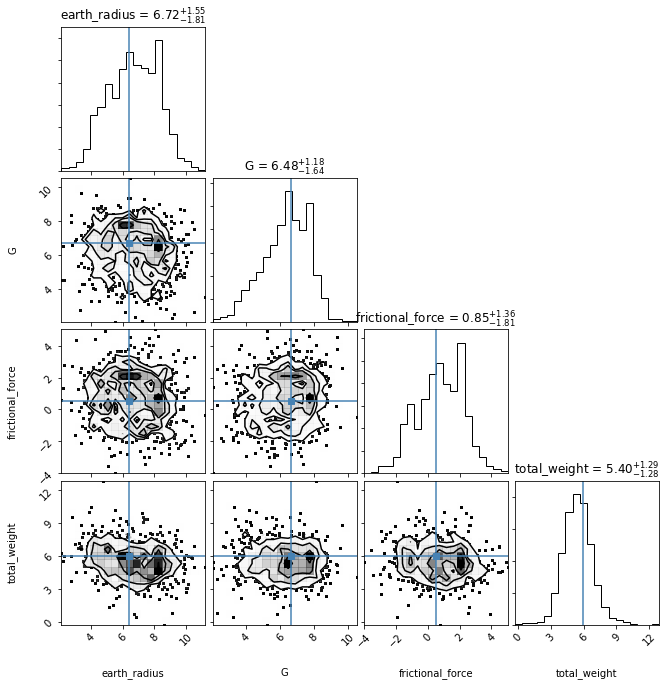

In [258]:
figure = corner.corner(sampler.flatchain[:],labels=["earth_radius","G","frictional_force", "total_weight"],truths=[6.371,6.67408,0.5, 5.972],show_titles=True)

# Conclusion

For length 400, emcee is successful in determining to an extent where the true values are. As evident by the peaks in the corner plot, the true value does have a high probability. For some, it is not the highest because there are two peaks. The varied peaks also impacts the mean value and sets it off from the true ones.

The trend from 200 to 400 indicate that as more data is generated, the results would be more accurate. The analysis for 400 length with 1000 step took me more than 3 hours to run, so my computer cannot physically handle running for length 600 or increasing the steps. 

### Extension

For extension I would want to first improve my simulation by having a sphere with radius of at least 500. I would require the right hardware to do so. I would also improve the analysis for emcee by increasing the length of the simulation to at least 1000 and the number of steps to around 5000. I believe I would be able to attain the correct results then. I could also improve how frictional force is calculated and instead use the formula for air resistance. Then, instead of optimizing for frictional force, I would optimize the drag coefficient and the surface area of the object. I didn't do this in this project because the calculations will be even more computationally intensive than now, and I would need to have more walkers and more steps to create results for a 5 dimensional analysis that is accurate enough. 